## Raman SV - Data 512 - Assignment 1

Snippets of code in this document are either used as is or modified based on the example code shared by Dr. David McDonald, professor for Data 512
This is from the notebook - "wp_article_views_example" shared as part of the starter code for this assignment

Import  the necessary libraries and packages for this project and setup the local environment

In [2]:
import os
import json, time, urllib.parse
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import seaborn as sns
import datetime

pd.set_option('display.max_colwidth', None)
Curr_Dir = 'C:/Users/raman/OneDrive/Desktop/UDubs/Classroom/Q4/Data 512 - HCDE/Assignments/Data512_UW_RS/data-512-homework_1'



Import the list of movies that will act as the source. Source file courtesy of Dr. David McDonald, professor for Data 512

In [3]:
movies = pd.read_excel(os.path.join(Curr_Dir, 'thank_the_academy.AUG.2023.csv.xlsx'))
movies.head(100)

,name,url
0,Everything Everywhere All at Once,https://en.wikipedia.org/wiki/Everything_Everywhere_All_at_Once
1,All Quiet on the Western Front (2022 film),https://en.wikipedia.org/wiki/All_Quiet_on_the_Western_Front_(2022_film)
2,The Whale (2022 film),https://en.wikipedia.org/wiki/The_Whale_(2022_film)
3,Top Gun: Maverick,https://en.wikipedia.org/wiki/Top_Gun:_Maverick
4,Black Panther: Wakanda Forever,https://en.wikipedia.org/wiki/Black_Panther:_Wakanda_Forever
...,...,...
95,Fences (film),https://en.wikipedia.org/wiki/Fences_(film)
96,Fantastic Beasts and Where to Find Them (film),https://en.wikipedia.org/wiki/Fantastic_Beasts_and_Where_to_Find_Them_(film)
97,The Jungle Book (2016 film),https://en.wikipedia.org/wiki/The_Jungle_Book_(2016_film)
98,O.J.: Made in America,https://en.wikipedia.org/wiki/O.J.:_Made_in_America


### Pageview Variables initialization
The below code (and comments) is mainly derived from the aforementioned starter code for this assignment

In [4]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': '<jmic94@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# The below are the variables to be used for parsing through the movie list for a particular period
ARTICLE_TITLES = list(movies.name)

DATE_START = '201507'
DATE_END = '202309'


# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       DATE_START + "0100",   # start and end dates need to be set
    "end":         DATE_END + "0100"    # this is likely the wrong end date
}



### Pageview per article function
This has been imported and modified from the code provided in the helper code

In [5]:

def request_pageviews_per_article(article_title = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


Below is the code that utilizes the above function to get the mobile pageviews per movie.

The original parameter specified desktop, the below code updates the variable to mobile-app or mobile-web

In [6]:
PageViews_Mob_App = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE.copy()
PageViews_Mob_App['access'] = 'mobile-app'

PageViews_Mob_Web = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE.copy()
PageViews_Mob_Web['access'] = 'mobile-web'

The below 3 code cells utilize the above functions to generate the pageview details for 3 request types - mobile app, mobile browser and desktop access.
Once the details are obtained, they are saved as CSV documents to aid further use and analysis

Create the dataframes that will be used in the code

In [ ]:

Mob_App_df = pd.DataFrame()
Mob_Web_df = pd.DataFrame()
Desktop_df = pd.DataFrame()

The below code uses the function defined earlier (request_pageviews_per_article) to get the data for the mobile app views

The parameter that filters this condition was defined above

This code and the subsequent ones use conditions to not error out if the response received didn't have any "items" returned

In [7]:
# Get the page views for the mobile app


for i, title in enumerate(ARTICLE_TITLES):
    PageViews = request_pageviews_per_article(title, request_template=PageViews_Mob_App)

    # Had to add the below logic as a keyerror for items was being returned for the code, this handles
    # scenarios where items is not part of the response for any reason
    if PageViews is not None and isinstance(PageViews, dict):
        if 'items' in PageViews:
            items = PageViews['items']
            temp_df = pd.DataFrame(PageViews['items'])
            Mob_App_df = pd.concat([Mob_App_df, temp_df])
        else:
            print("'items' not found in response")
    else:
         print("No valid response")

# Export the above data as a csv file
Mob_App_df.to_csv(
    os.path.join(Curr_Dir, 'CSV_Files/Mobile_App_Page_Views.csv'), index=False)

'items' not found in response


The below code uses the function defined earlier (request_pageviews_per_article) to get the data for the mobile web views

The parameter that filters this condition was defined above

In [8]:
# Get the page views for the mobile web

for i, title in enumerate(ARTICLE_TITLES):
    PageViews = request_pageviews_per_article(title, request_template=PageViews_Mob_Web)

    if PageViews is not None and isinstance(PageViews, dict):
        if 'items' in PageViews:
            items = PageViews['items']
            temp_df = pd.DataFrame(PageViews['items'])
            Mob_Web_df = pd.concat([Mob_Web_df, temp_df])
        else:
            print("'items' not found in response")
    else:
         print("No valid response")

# Export the above data as a csv file
Mob_Web_df.to_csv(
    os.path.join(Curr_Dir, 'CSV_Files/Mobile_Web_Page_Views.csv'), index=False)

'items' not found in response


The below code uses the function defined earlier (request_pageviews_per_article) to get the data for the desktop views



In [9]:
# Get the page views for Desktop

for i, title in enumerate(ARTICLE_TITLES):
    PageViews = request_pageviews_per_article(title, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)

    if PageViews is not None and isinstance(PageViews, dict):
        if 'items' in PageViews:
            items = PageViews['items']
            temp_df = pd.DataFrame(PageViews['items'])
            Desktop_df = pd.concat([Desktop_df, temp_df])
        else:
            print("'items' not found in response")
    else:
         print("No valid response")

Desktop_df.to_csv(
    os.path.join(Curr_Dir, 'CSV_Files/Desktop_Page_Views.csv'), index=False)

'items' not found in response


### Creating JSON datasets for the data collected in the previous steps

The below 2 code cells create JSON datasets that can be used for further analysis

The mobile views cell combines the views from both web and app for mobile data.

The 'article' field acts as a key in the JSON outputs

In [10]:
# Combine the monthly views data for the 2 mobile sources - app and web

Mob_PV_by_Month = pd.concat([Mob_App_df, Mob_Web_df])


# Combine the numbers from the 2 datasets
Mob_PV_by_Month = Mob_PV_by_Month.groupby(['project', 'article', 'granularity', 'timestamp', 'agent'])['views'].sum().reset_index()

# Reorder the dataframe and add an identifier for the source
column_order = ['article', 'project', 'granularity', 'timestamp', 'agent', 'views']
Mob_PV_by_Month = Mob_PV_by_Month[column_order]
Mob_PV_by_Month['Source'] = 'Mobile- app and web'

# Create the JSON file
filename = 'academy_monthly_mobile_' + DATE_START + '-' + DATE_END + '.json'
Mob_PV_by_Month.to_json(os.path.join(Curr_Dir, 'pageviews', filename), orient='records', lines=True)

In [11]:
# Get the data for the desktop views
Desktop_PV_by_Month = Desktop_df.groupby(['project', 'article', 'granularity', 'timestamp', 'agent'])['views'].sum().reset_index()

# Reorder the dataframe and add an identifier for the source
column_order = ['article', 'project', 'granularity', 'timestamp', 'agent', 'views']
Desktop_PV_by_Month = Desktop_PV_by_Month[column_order]
Desktop_PV_by_Month['Source'] = 'Desktop'

# Create the JSON file
filename = 'academy_monthly_desktop_' + DATE_START + '-' + DATE_END + '.json'
Desktop_PV_by_Month.to_json(os.path.join(Curr_Dir, 'pageviews', filename), orient='records', lines=True)

### Cumulative views
This is obtained by combined the data from all 3 datasets

In [12]:
# Combine the 3 datasets and sort them
Combined_PV_by_Month = pd.concat([Mob_App_df, Mob_Web_df, Desktop_df])
Combined_PV_by_Month.sort_values(['article', 'timestamp'], inplace=True)

# Get the total views for this combined set
Combined_PV_by_Month = Combined_PV_by_Month.groupby(['project', 'article', 'granularity','timestamp', 'agent']).sum('views').reset_index()
Combined_PV_by_Month['total_views'] = Combined_PV_by_Month.groupby('article')['views'].cumsum()

# Reorder the dataframe and add an identifier for the source
column_order = ['article', 'project', 'granularity', 'timestamp', 'agent', 'views']
Desktop_PV_by_Month = Desktop_PV_by_Month[column_order]
Desktop_PV_by_Month['Source'] = 'Combined - Desktop and Mobile - web and app'

# Create the JSON file
filename = 'academy_monthly_cumulative_' + DATE_START + '-' + DATE_END + '.json'
Desktop_PV_by_Month.to_json(os.path.join(Curr_Dir, 'pageviews', filename), orient='records', lines=True)

## Visualization

The below segments create visuals for various views and they combine the data from mobile and desktop (although demarcated in the visuals) to generate visual represenations

#### Visualization 1: Maximum Average and Minimum Average

This graph is a time series representation for the articles with the highest average monthly page requests and the lowest average monthly page requests across both desktop and mobile interfaces.

A note for the below as well as subsequent visualization cells: a variable "UW_colors" has been defined that inculcates brand coloring in line with the University of Washington brand scheme.
These colors can be found on the site "https://www.washington.edu/brand/graphic-elements/primary-color-palette/"

Update the parameter if you want your own color scheme.

Further, the dots vs dash lines are determined by Mobile and Desktop views, this can be eliminated or modified based on your data.

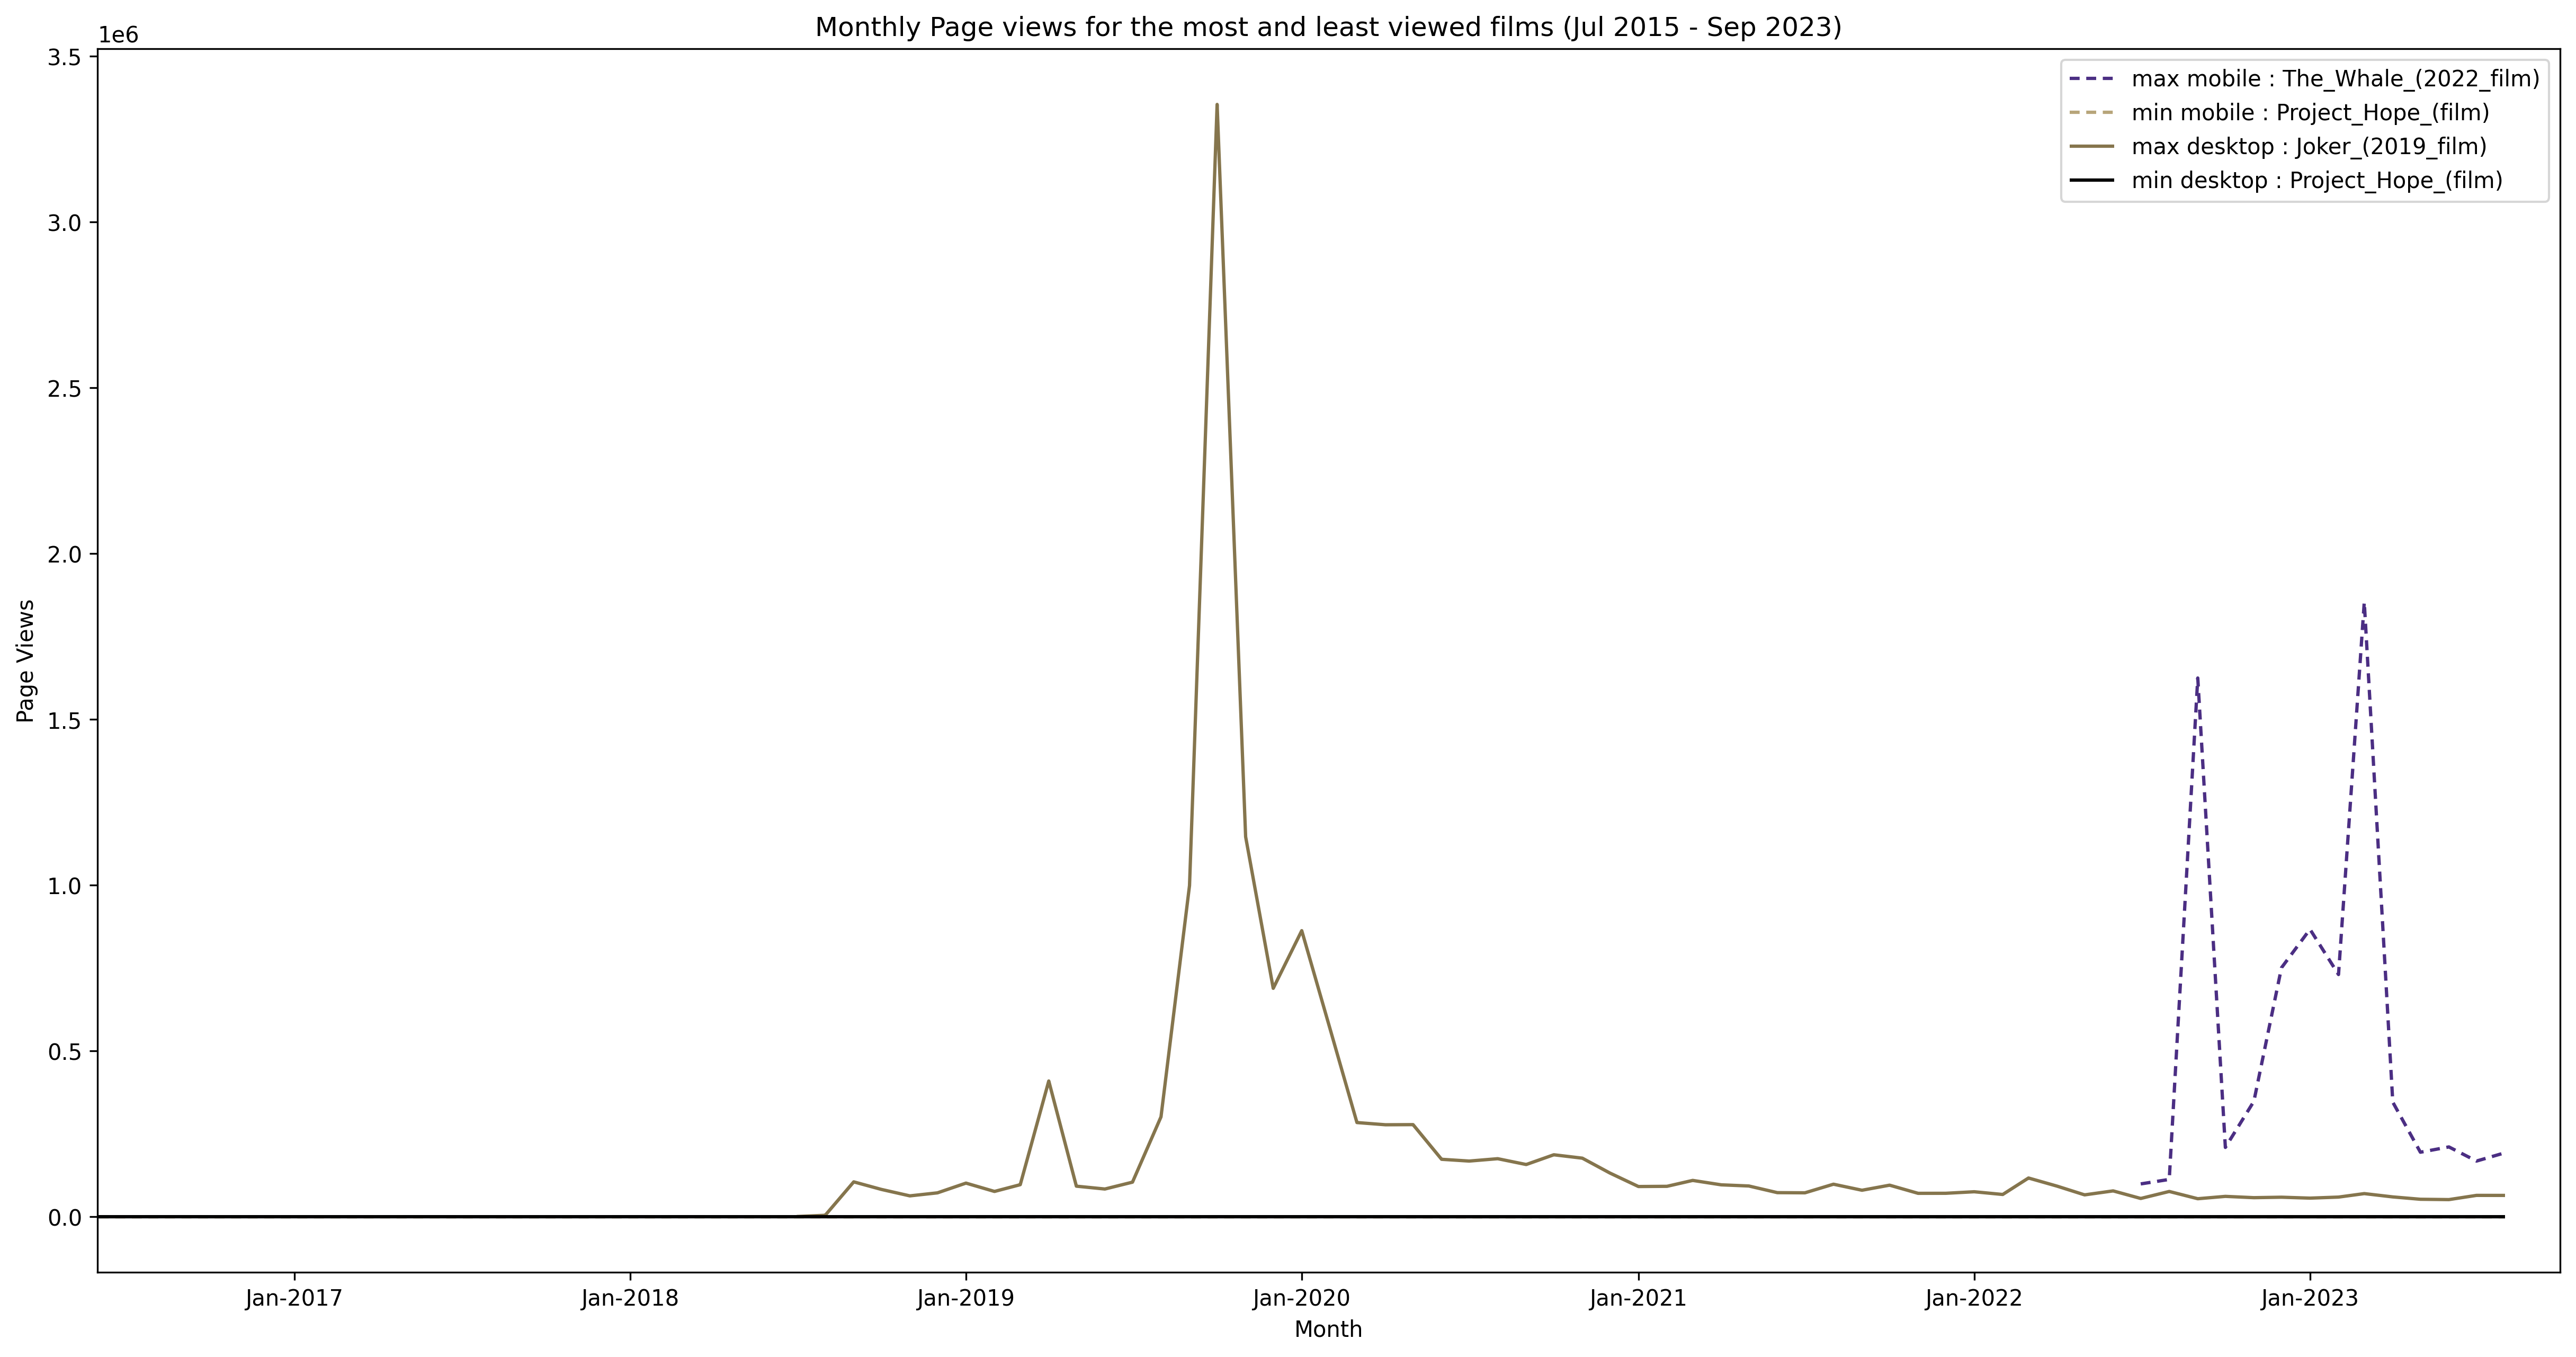

In [18]:

# Combine mobile monthly view by movie and get the maximum and minimum averages
Mob_PV_avg_by_Month = Mob_PV_by_Month.groupby('article').mean('views').reset_index()
Mob_PV_avg_by_Month.sort_values('views', ascending=False, inplace=True)
Mob_PV_max_avg = Mob_PV_avg_by_Month.article.values[0]
Mob_PV_min_avg = Mob_PV_avg_by_Month.article.values[-1]

# Combine desktop monthly view by movie and get the maximum and minimum averages
Desktop_PV_avg_by_Month = Desktop_PV_by_Month.groupby('article').mean('views').reset_index()
Desktop_PV_avg_by_Month.sort_values('views', ascending=False, inplace=True)
Desktop_PV_max_avg = Desktop_PV_avg_by_Month.article.values[0]
Desktop_PV_min_avg = Desktop_PV_avg_by_Month.article.values[-1]

# Define the variables for the max and min values for both mobile and desktop

# Mobile variables
Mob_max = Mob_PV_by_Month[Mob_PV_by_Month.article == Mob_PV_max_avg].copy()
Mob_max['label'] = 'max mobile'
Mob_min = Mob_PV_by_Month[Mob_PV_by_Month.article == Mob_PV_min_avg].copy()
Mob_min['label'] = 'min mobile'

# Desktop variables
Desktop_max = Desktop_PV_by_Month[Desktop_PV_by_Month.article == Desktop_PV_max_avg].copy()
Desktop_max['label'] = 'max desktop'
Desktop_min = Desktop_PV_by_Month[Desktop_PV_by_Month.article == Desktop_PV_min_avg].copy()
Desktop_min['label'] = 'min desktop'

# Combine the above created datasets
averages = pd.concat([Mob_max, Mob_min, Desktop_max, Desktop_min])
averages['month'] = averages.timestamp.str[:8]
averages['month'] = pd.to_datetime(averages.month)
averages['label'] = averages['label'] + ' : ' + averages['article']

# Using UW Brand color scheme
UW_colors = ["#4b2e83", "#b7a57a", "#85754d", "#000000", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Create dashed vs dotted line styles for desktop and mobile
line_styles = {}
for label in averages['label'].unique():
    if 'desktop' in label:
        line_styles[label] = (1, 0)
    elif 'mobile' in label:
        line_styles[label] = (3, 2)

# Define the parameters to create the plots
plt.figure(figsize=(20, 10), dpi=300)
sns.set_palette(UW_colors)  # Set the custom color palette
sns.lineplot(data=averages, x='month', y='views', hue='label', style='label', dashes=line_styles)

date_format = mdates.DateFormatter('%b-%Y')
plt.gca().xaxis.set_major_formatter(date_format)

start_date = datetime.datetime(2016, 6, 1)
end_date = datetime.datetime(2023, 9, 30)
plt.xlim(start_date, end_date)

plt.xlabel('Month')
plt.ylabel('Page Views')
plt.title('Monthly Page views for the most and least viewed films (Jul 2015 - Sep 2023)')

desktop_line = mlines.Line2D([], [], color='black', linestyle='-', label='desktop')
mobile_line = mlines.Line2D([], [], color='black', linestyle='--', label='mobile')

plt.legend(title='')
plt.savefig(os.path.join(Curr_Dir, 'Images/avg_max_min.png'))

#### Visualization 2: Top 10 Peak Page Views

This graph is a time series representation of the top 10 article pages by peak page views across access type.

The graph visualizes the top 10 items for desktop as well as the combined mobile access


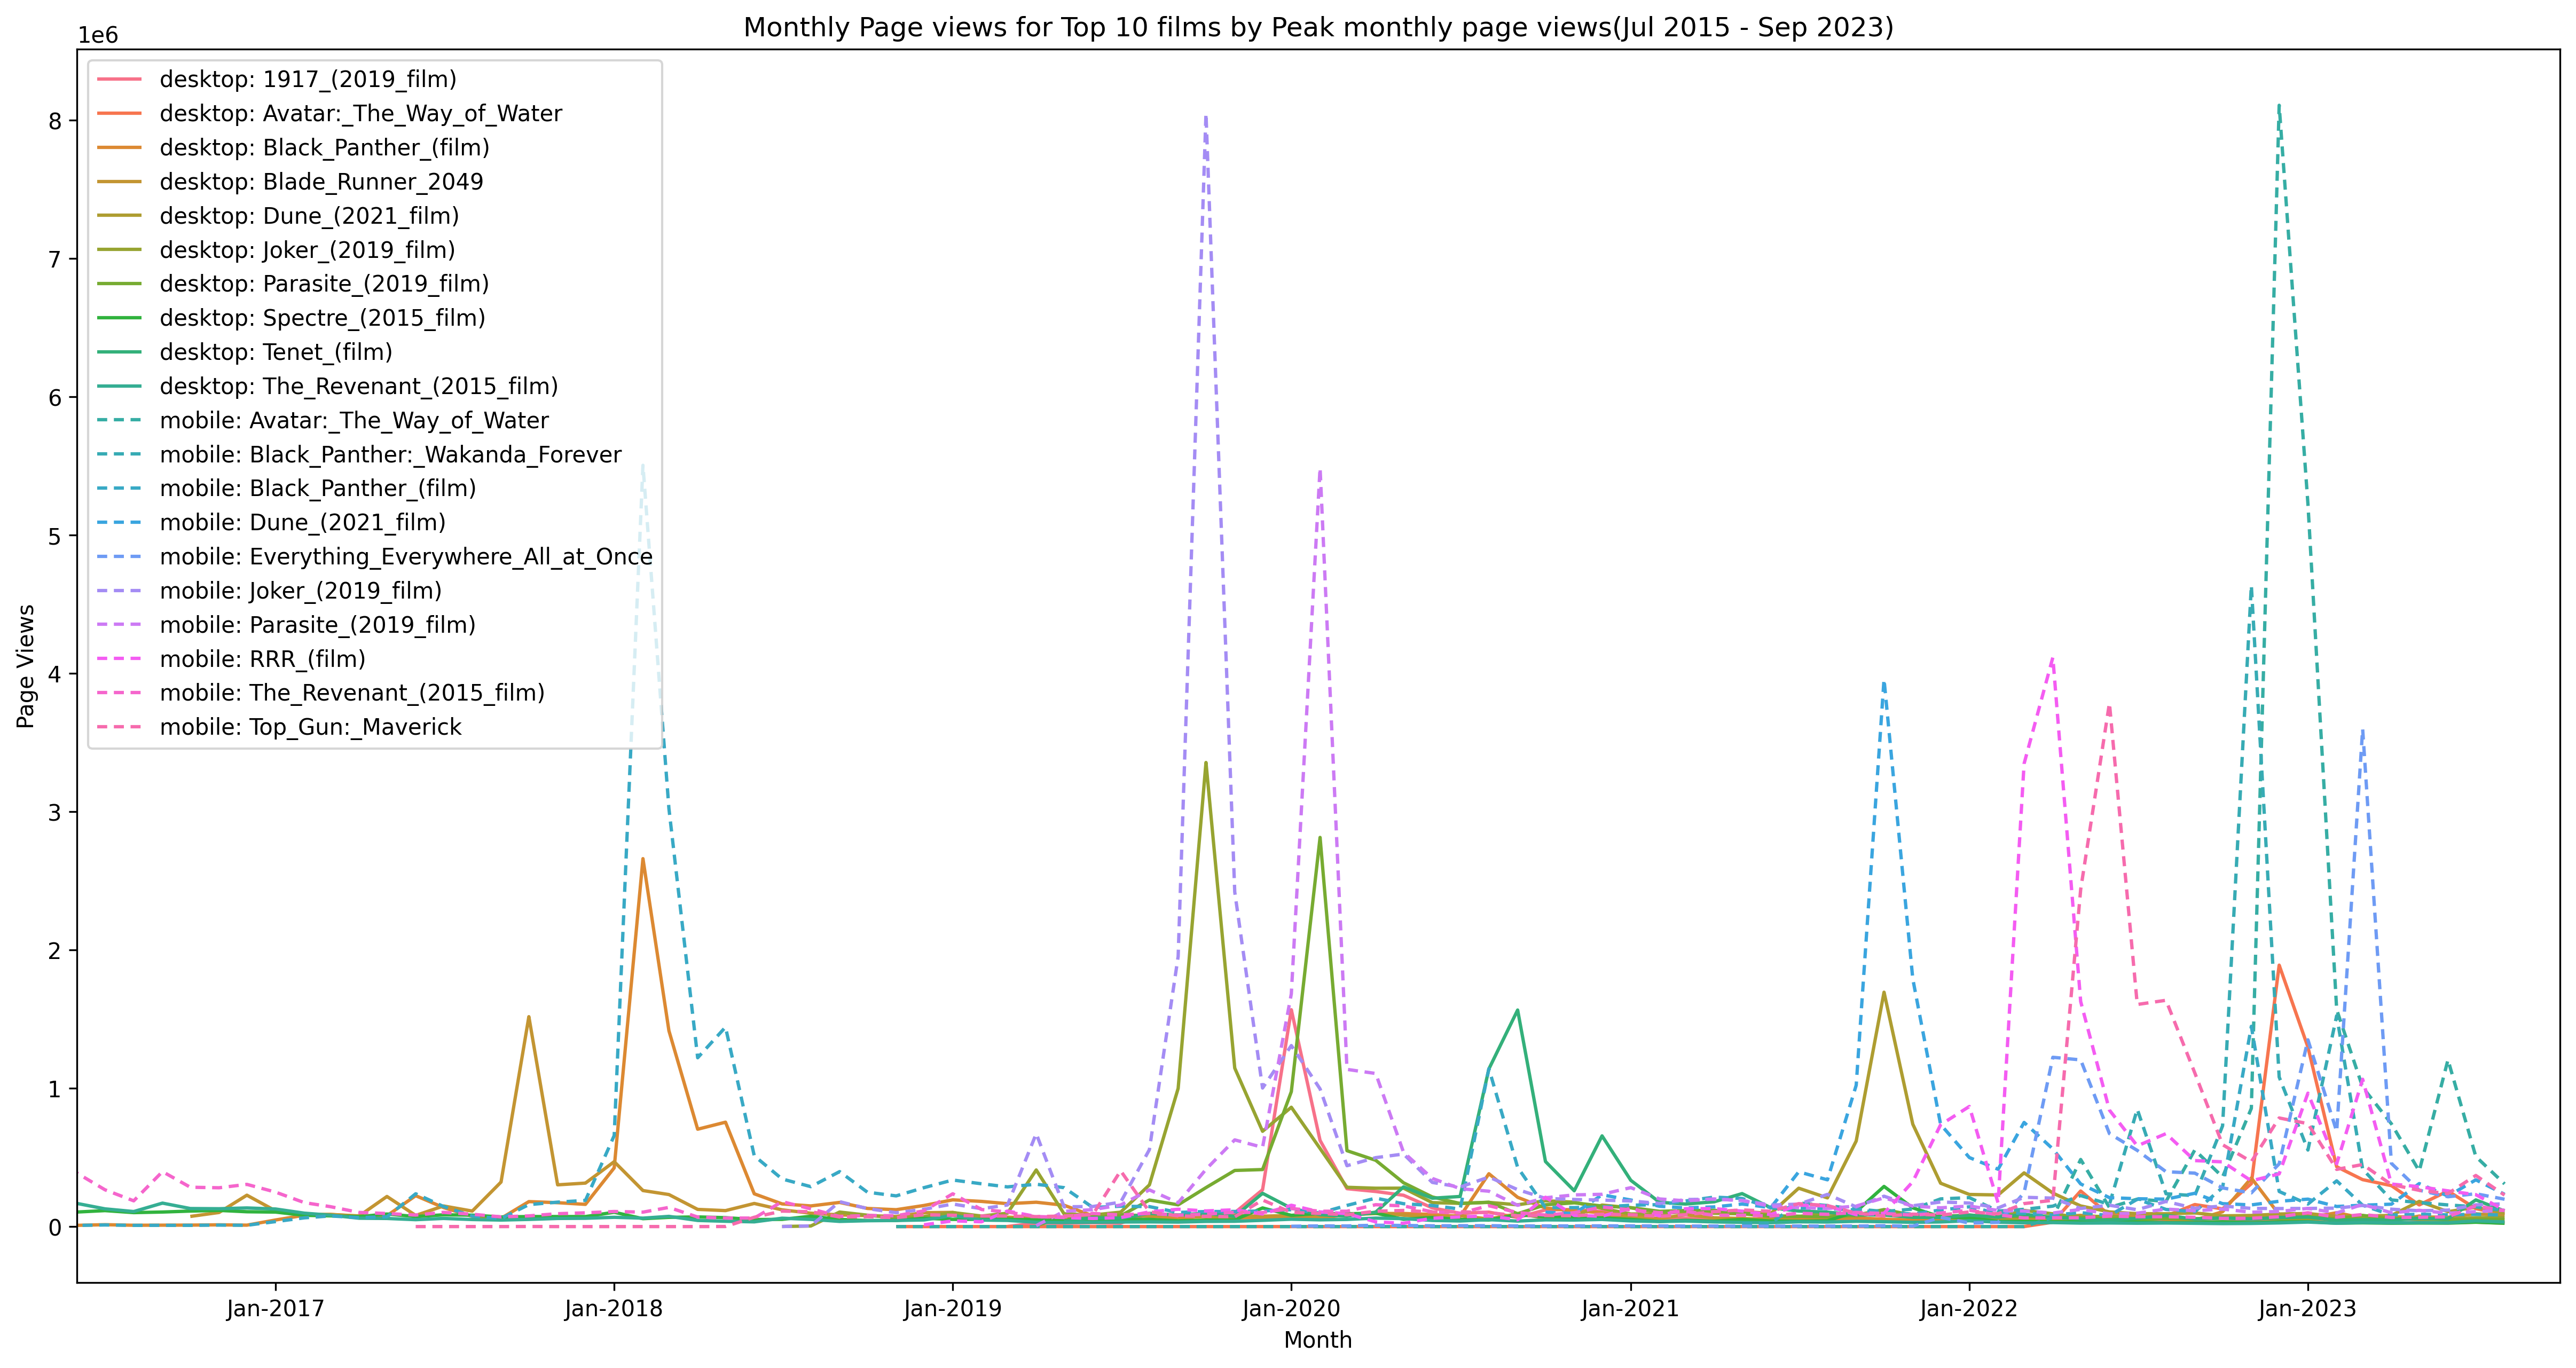

In [17]:
# get the top 10 peaks by month for mobile
Mob_max_by_month = Mob_PV_by_Month.groupby('article')['views'].max().reset_index()
Mob_max_by_month.sort_values('views', ascending=False, inplace=True)
Mob_max_by_month = Mob_max_by_month.head(10)
Mob_top10_peaks = Mob_PV_by_Month[Mob_PV_by_Month['article'].isin(Mob_max_by_month.article)].copy()
Mob_top10_peaks['label'] = 'mobile'

# get the top 10 peaks by month for desktop
Desktop_max_by_month = Desktop_PV_by_Month.groupby('article')['views'].max().reset_index()
Desktop_max_by_month.sort_values('views', ascending=False, inplace=True)
Desktop_max_by_month = Desktop_max_by_month.head(10)
Desktop_top10_peaks = Desktop_PV_by_Month[Desktop_PV_by_Month['article'].isin(Desktop_max_by_month.article)].copy()
Desktop_top10_peaks['label'] = 'desktop'

# Combine the top 10 peaks by month for mobile and desktop
top10_peaks = pd.concat([Desktop_top10_peaks, Mob_top10_peaks])
top10_peaks['month'] = top10_peaks.timestamp.str[:8]
top10_peaks['month'] = pd.to_datetime(top10_peaks.month)
top10_peaks['label'] = top10_peaks['label'] + ': ' + top10_peaks['article']
top10_peaks.sort_values(['label'], inplace=True)


# Using UW Brand color scheme
UW_colors = ["#4b2e83", "#b7a57a", "#85754d", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#2b9f78", "#ff796c", "#9966cc"]

# Create dashed vs dotted line styles for desktop and mobile
line_styles = {}
for label in top10_peaks['label'].unique():
    if label.startswith('desktop'):
        line_styles[label] = (1, 0)
    elif label.startswith('mobile'):
        line_styles[label] = (3, 2)

# Define the parameters to create the plots
plt.figure(figsize=(20, 10), dpi=300)
sns.set_palette(UW_colors)  # Set the custom color palette
sns.lineplot(data=top10_peaks, x='month', y='views', hue='label', style='label', dashes=line_styles)
date_format = mdates.DateFormatter('%b-%Y')
plt.gca().xaxis.set_major_formatter(date_format)

start_date = datetime.datetime(2016, 6, 1)
end_date = datetime.datetime(2023, 9, 30)
plt.xlim(start_date, end_date)

plt.xlabel('Month')
plt.ylabel('Page Views')
plt.title('Monthly Page views for Top 10 films by Peak monthly page views(Jul 2015 - Sep 2023)')

desktop_line = mlines.Line2D([], [], color='black', linestyle='-', label='desktop')
mobile_line = mlines.Line2D([], [], color='black', linestyle='--', label='mobile')

plt.legend(title='')
plt.savefig(os.path.join(Curr_Dir, 'Images/top10_peaks.png'))

#### Visualization 3: Fewest Months of Data

This graph represents those movies that have the fewest months of available data for the most recent academy award winners.

The graph is a top 10 list of movies with the fewest months of data for both desktop and mobile access.


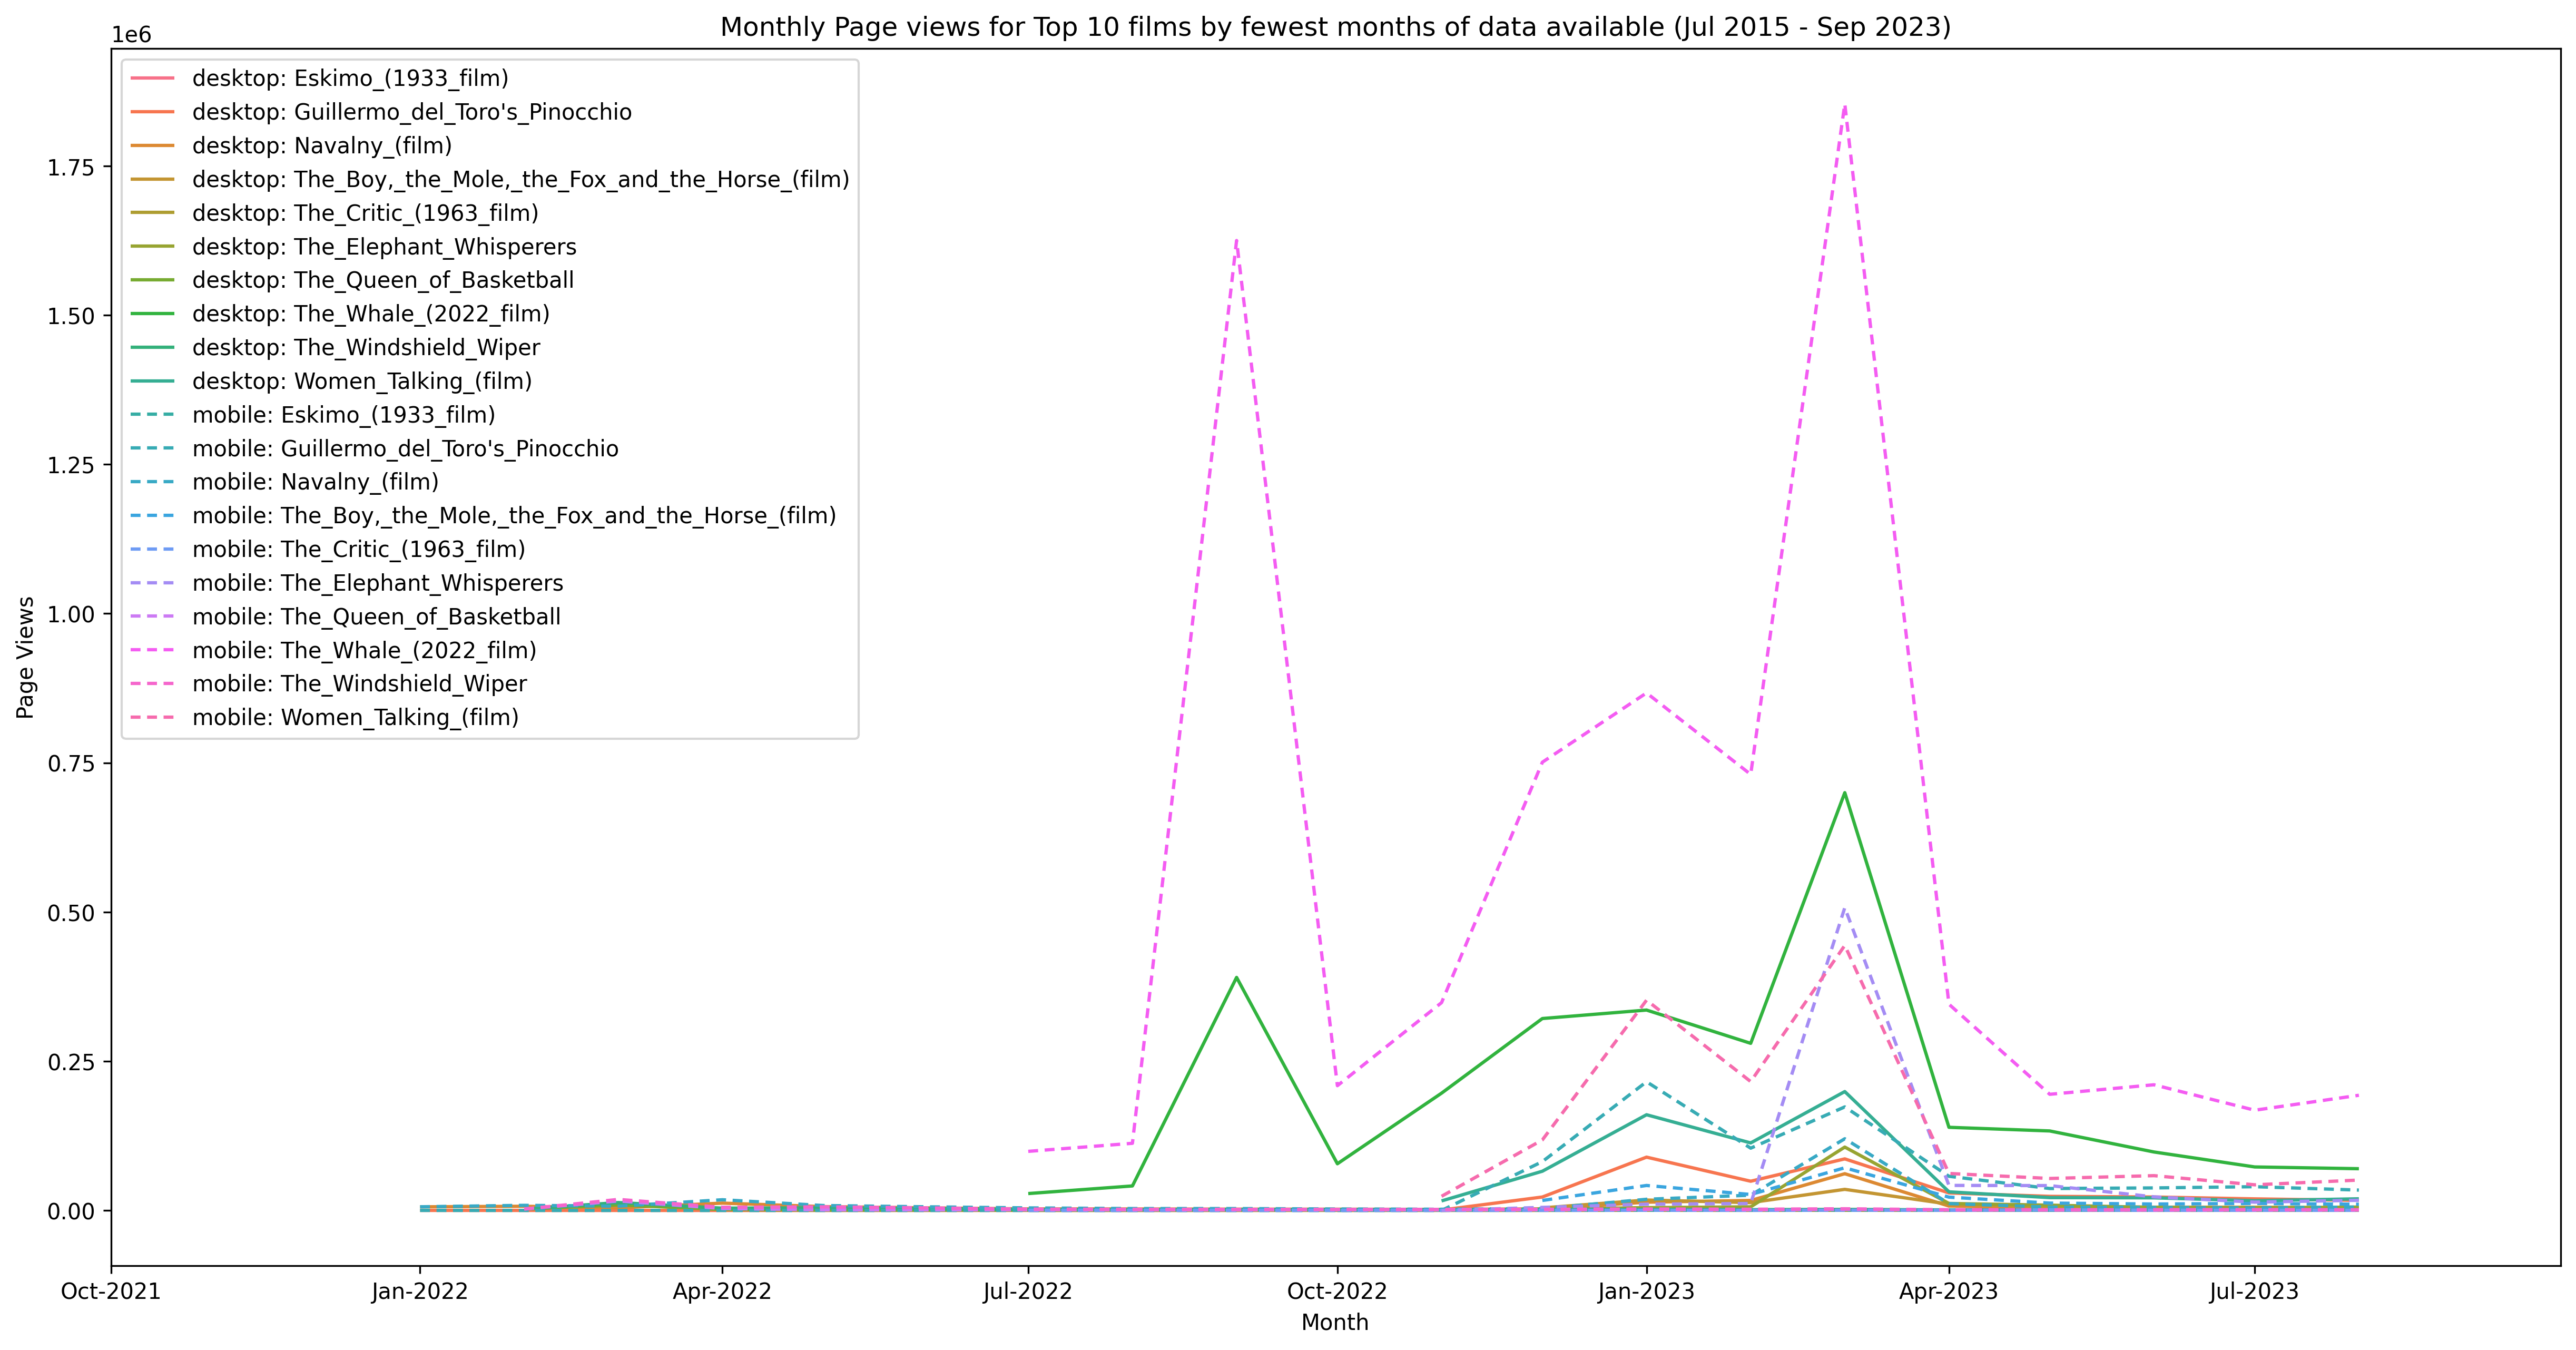

In [16]:
# get the top 10 fewest data by month for mobile
Mob_fewest_by_month = Mob_PV_by_Month.groupby('article')['timestamp'].count().reset_index()
Mob_fewest_by_month.sort_values('timestamp', ascending=True, inplace=True)
Mob_fewest_by_month = Mob_fewest_by_month.head(10)
top_10_few_mobile = Mob_PV_by_Month[Mob_PV_by_Month['article'].isin(Mob_fewest_by_month.article)].copy()
top_10_few_mobile['label'] = 'mobile'

# get the top 10 fewest data by month for desktop
Desktop_fewest_by_month = Desktop_PV_by_Month.groupby('article')['timestamp'].count().reset_index()
Desktop_fewest_by_month.sort_values('timestamp', ascending=True, inplace=True)
Desktop_fewest_by_month = Desktop_fewest_by_month.head(10)
top_10_few_desktop = Desktop_PV_by_Month[Desktop_PV_by_Month['article'].isin(Desktop_fewest_by_month.article)].copy()
top_10_few_desktop['label'] = 'desktop'

# Combine the top 10 fewest data by month for mobile and desktop
top10_fewest = pd.concat([top_10_few_desktop, top_10_few_mobile])
top10_fewest['month'] = top10_fewest.timestamp.str[:8]
top10_fewest['month'] = pd.to_datetime(top10_fewest.month)
top10_fewest['label'] = top10_fewest['label'] + ': ' + top10_fewest['article']
top10_fewest.sort_values(['label'], inplace=True)


# Using UW Brand color scheme
UW_colors = ["#4b2e83", "#b7a57a", "#85754d", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#2b9f78", "#ff796c", "#9966cc"]

# Create dashed vs dotted line styles for desktop and mobile
line_styles = {}
for label in top10_fewest['label'].unique():
    if label.startswith('desktop'):
        line_styles[label] = (1, 0)
    elif label.startswith('mobile'):
        line_styles[label] = (3, 2)


# Define the parameters to create the plots
plt.figure(figsize=(20, 10), dpi=300)
sns.set_palette(UW_colors)  # Set the custom color palette
sns.lineplot(data=top10_fewest, x='month', y='views', hue='label', style='label', dashes=line_styles)

date_format = mdates.DateFormatter('%b-%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

start_date = datetime.datetime(2021, 10, 1)
end_date = datetime.datetime(2023, 9, 30)
plt.xlim(start_date, end_date)

plt.xlabel('Month')
plt.ylabel('Page Views')
plt.title('Monthly Page views for Top 10 films by fewest months of data available (Jul 2015 - Sep 2023)')

desktop_line = mlines.Line2D([], [], color='black', linestyle='-', label='desktop')
mobile_line = mlines.Line2D([], [], color='black', linestyle='--', label='mobile')

plt.legend(title='')
plt.savefig(os.path.join(Curr_Dir, 'Images/top10_fewest.png'))